In [1]:
!pip install ultralytics

import os
import cv2
import torch
from ultralytics import YOLO
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 976.9/976.9 kB 24.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ‚úÖ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
# Verify model path
MODEL_PATH = "/kaggle/input/detection_yolo/pytorch/default/1/best.pt"
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH}")

# Verify YAML file path
DATA_YAML_PATH = "/kaggle/input/data-file/data.yaml"
if not os.path.exists(DATA_YAML_PATH):
    raise FileNotFoundError(f"YAML file not found at {DATA_YAML_PATH}")

# Load YOLO Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = YOLO(MODEL_PATH).to(device)

print(f"Model loaded successfully on {device}!")

Model loaded successfully on cuda!



0: 640x640 4 cabbages, 4 potatos, 13 tomatos, 8.4ms
Speed: 12.7ms preprocess, 8.4ms inference, 273.5ms postprocess per image at shape (1, 3, 640, 640)


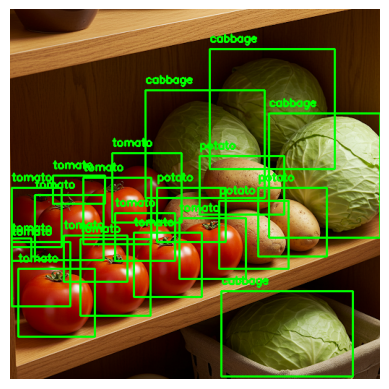


0: 640x640 1 cabbage, 6 potatos, 7 tomatos, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


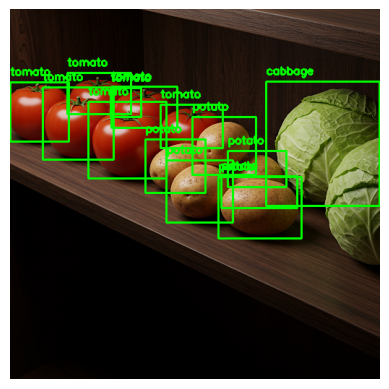


0: 640x640 4 potatos, 11 tomatos, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


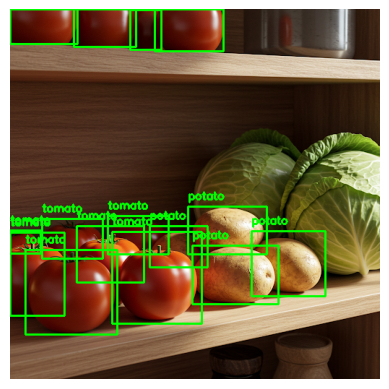

üéâ Processing complete. Check the 'cropped_images' and 'annotated_images' folders.


In [3]:
import os
import cv2
import yaml
from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt

# Paths
MODEL_PATH = "/kaggle/input/detection_yolo/pytorch/default/1/best.pt"  # Ensure the correct path
TEST_IMAGES_PATH = "/kaggle/input/shelf-images/gen_images_veg"
OUTPUT_PATH = "cropped_images"
ANNOTATED_OUTPUT_PATH = "annotated_images"
DATA_YAML_PATH = "/kaggle/input/data-file/data.yaml"

# Ensure output directory exists
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(ANNOTATED_OUTPUT_PATH, exist_ok=True)

# Load YOLO Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = YOLO(MODEL_PATH).to(device)

# Load YAML file correctly
with open(DATA_YAML_PATH, "r") as file:
    data_yaml = yaml.safe_load(file)  # Now data_yaml is a dictionary

# Process images
for img_name in os.listdir(TEST_IMAGES_PATH):
    img_path = os.path.join(TEST_IMAGES_PATH, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"‚ö†Ô∏è Skipping {img_name}: Unable to read image.")
        continue
    
    results = model(img)
    cropped_objects = []
    
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy()
        names = result.names
        
        for i, (box, cls) in enumerate(zip(boxes, classes)):
            x1, y1, x2, y2 = map(int, box)
            class_name = names[int(cls)] if "names" in data_yaml else f"class_{int(cls)}"
            class_folder = os.path.join(OUTPUT_PATH, class_name)
            os.makedirs(class_folder, exist_ok=True)
            
            # Crop detected object
            cropped_img = img[y1:y2, x1:x2]
            cropped_img_path = os.path.join(class_folder, f"{img_name.split('.')[0]}_{i}.jpg")
            cv2.imwrite(cropped_img_path, cropped_img)
            cropped_objects.append((x1, y1, x2, y2, class_name))
    
    # Annotate original image after cropping
    for (x1, y1, x2, y2, class_name) in cropped_objects:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Save annotated image
    annotated_img_path = os.path.join(ANNOTATED_OUTPUT_PATH, img_name)
    cv2.imwrite(annotated_img_path, img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    
print("üéâ Processing complete. Check the 'cropped_images' and 'annotated_images' folders.")


In [4]:
OUTPUT_PATH = "/kaggle/working/cropped_images"

# Get the count of items per class
stock_count = {}

for class_name in os.listdir(OUTPUT_PATH):
    class_path = os.path.join(OUTPUT_PATH, class_name)
    if os.path.isdir(class_path):  # Ensure it's a folder
        stock_count[class_name] = len(os.listdir(class_path))  # Count images

# Print stock count
print("üì¶ Stock Prediction Results:")
for item, count in stock_count.items():
    print(f"{item}: {count} items")

üì¶ Stock Prediction Results:
cabbage: 5 items
tomato: 31 items
potato: 14 items


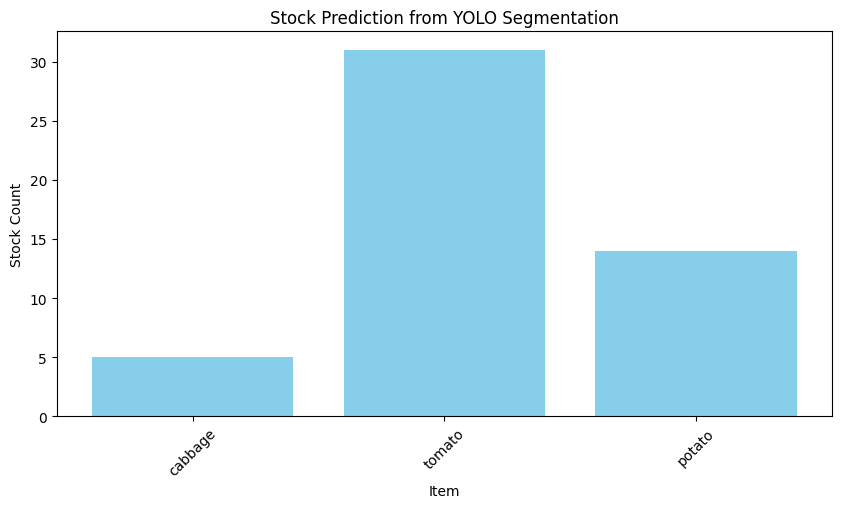

In [5]:
import matplotlib.pyplot as plt

# Plot Stock Levels
plt.figure(figsize=(10, 5))
plt.bar(stock_count.keys(), stock_count.values(), color='skyblue')
plt.xlabel("Item")
plt.ylabel("Stock Count")
plt.title("Stock Prediction from YOLO Segmentation")
plt.xticks(rotation=45)
plt.show()

Model loaded successfully.
Processing: unnamed (1)_8.jpg in cabbage
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 2s/step


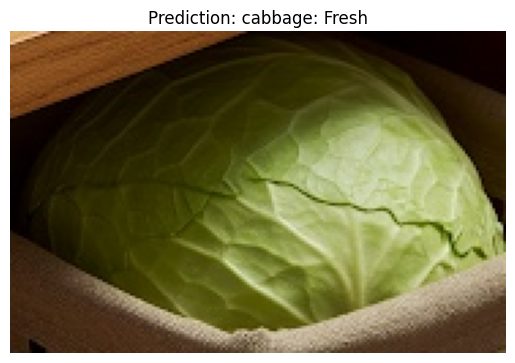

Processing: unnamed (1)_0.jpg in cabbage
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


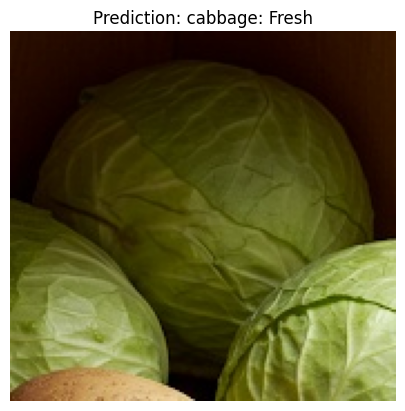

Processing: unnamed (1)_6.jpg in cabbage
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


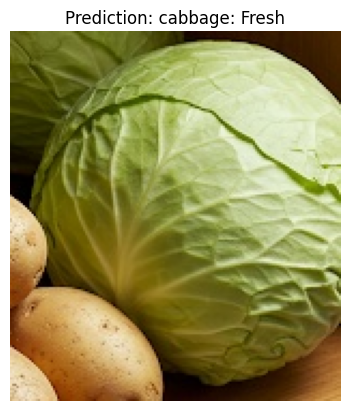

Processing: unnamed (1)_16.jpg in cabbage
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 21ms/step


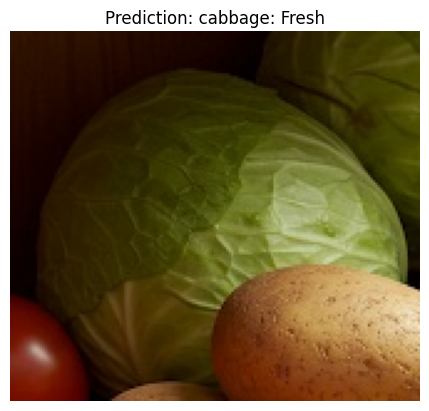

Processing: unnamed_10.jpg in cabbage
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


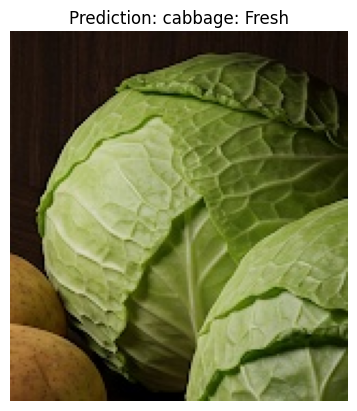

Processing: unnamed (1)_9.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


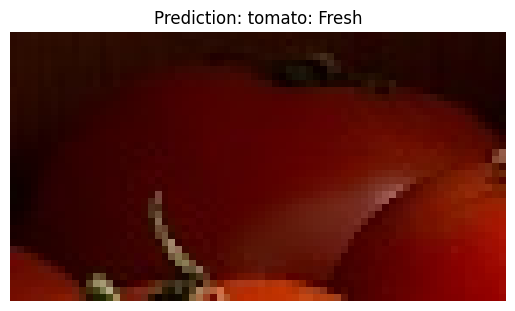

Processing: unnamed_2.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


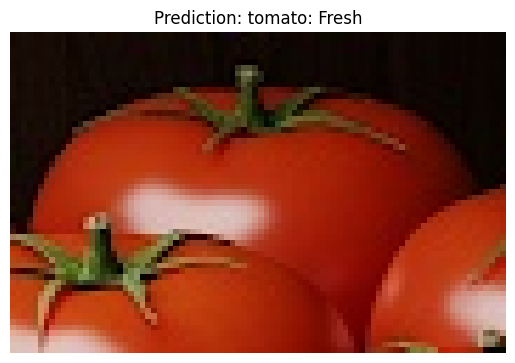

Processing: unnamed (1)_5.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


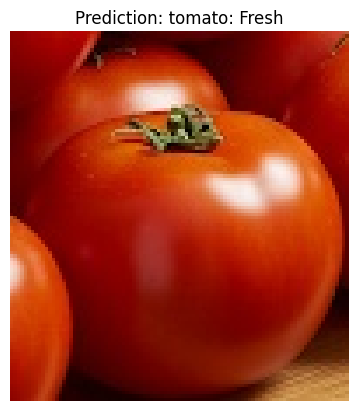

Processing: unnamed (2)_1.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


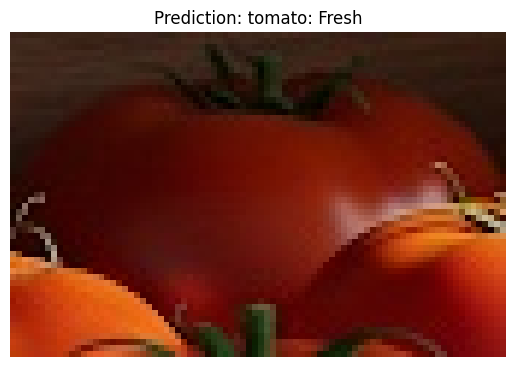

Processing: unnamed_13.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


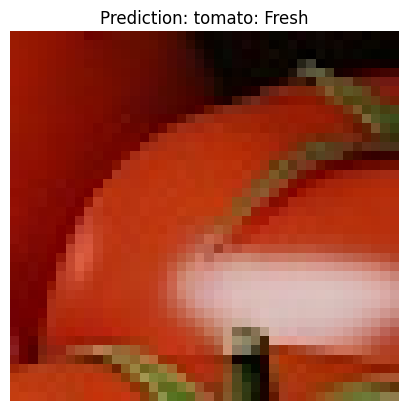

Processing: unnamed_8.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


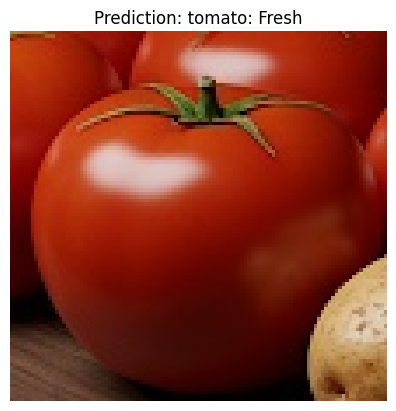

Processing: unnamed (1)_11.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


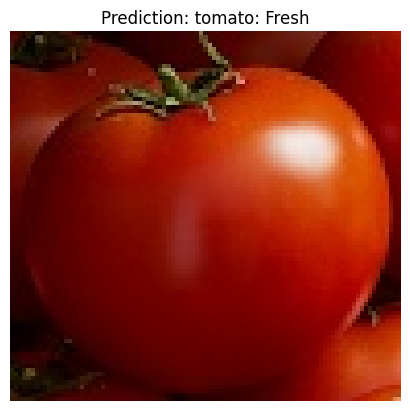

Processing: unnamed (1)_19.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/step


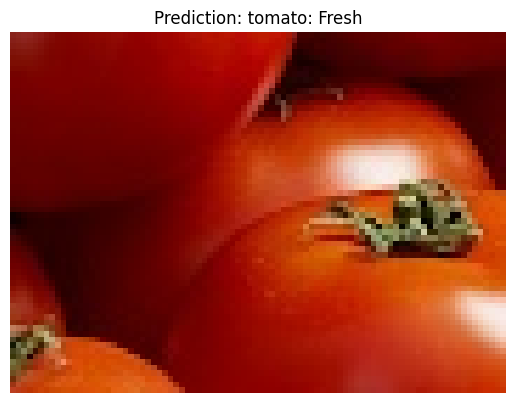

Processing: unnamed (2)_4.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/step


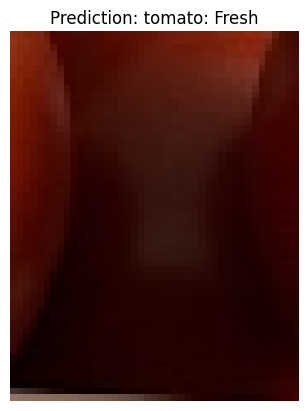

Processing: unnamed (2)_7.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


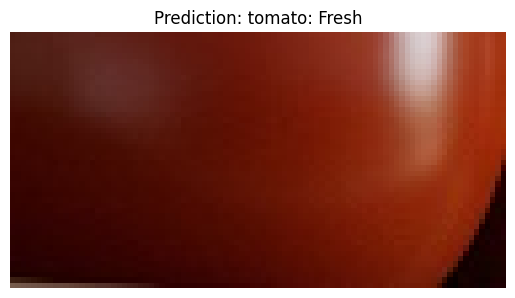

Processing: unnamed (2)_8.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/step


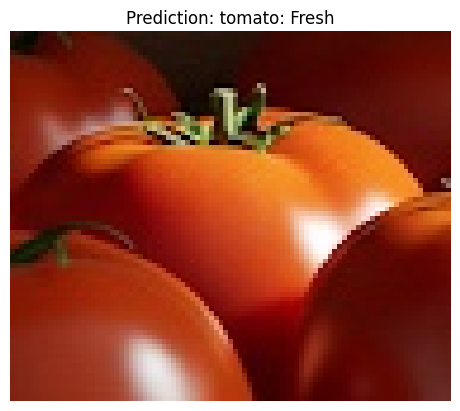

Processing: unnamed (2)_2.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


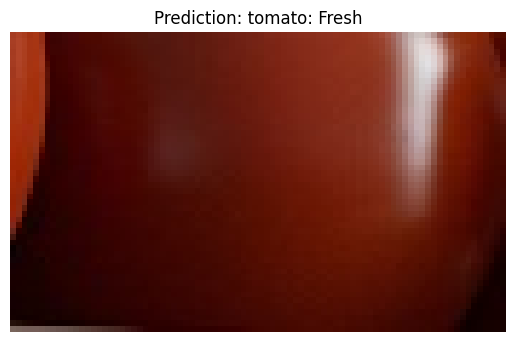

Processing: unnamed (1)_3.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 20ms/step


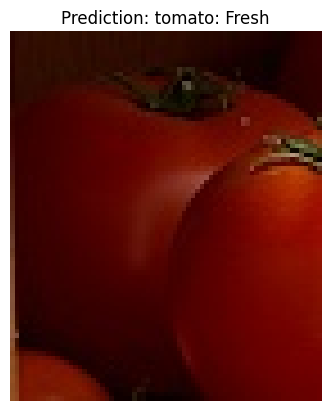

Processing: unnamed (2)_12.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


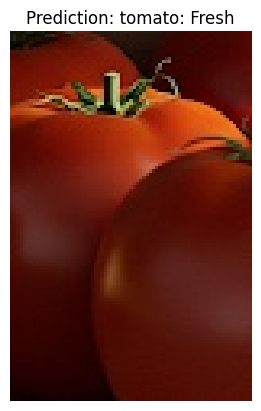

Processing: unnamed_4.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/step


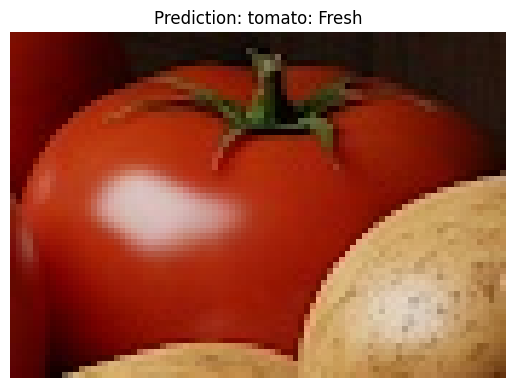

Processing: unnamed_6.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 20ms/step


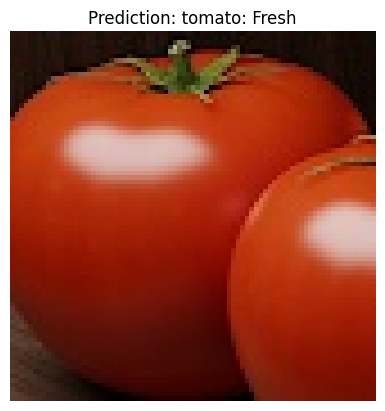

Processing: unnamed (1)_20.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


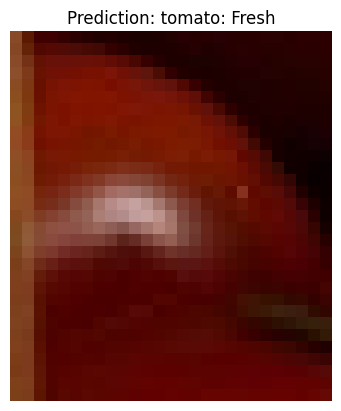

Processing: unnamed (1)_2.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/step


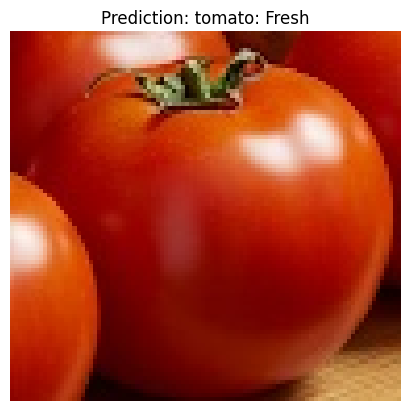

Processing: unnamed (1)_7.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


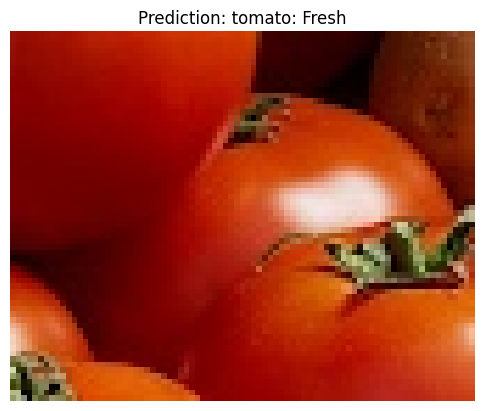

Processing: unnamed (2)_5.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


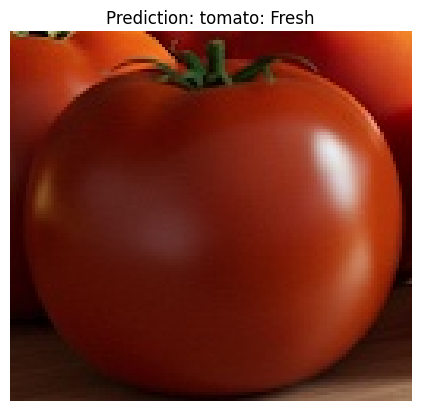

Processing: unnamed (2)_14.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


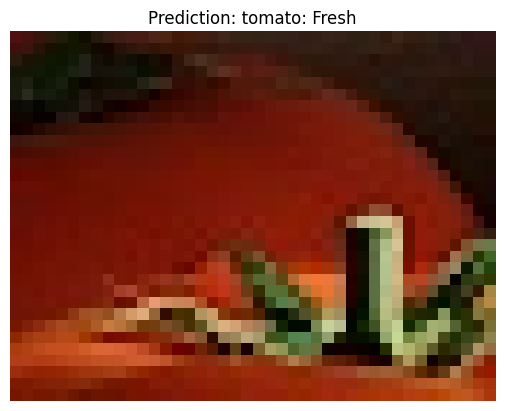

Processing: unnamed (1)_17.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


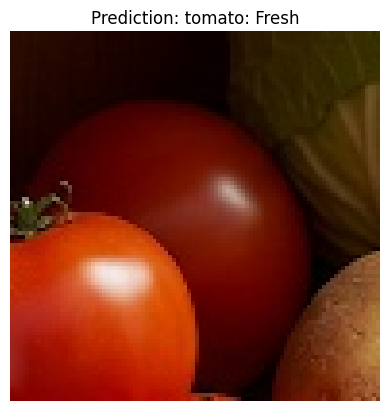

Processing: unnamed (2)_9.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


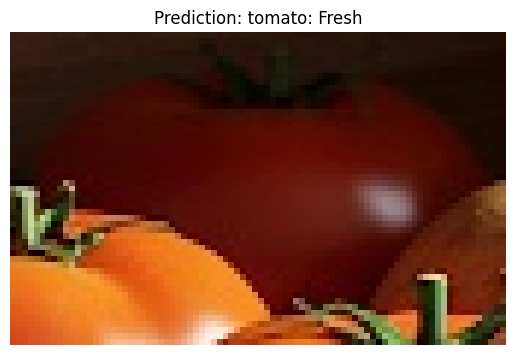

Processing: unnamed (1)_4.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/step


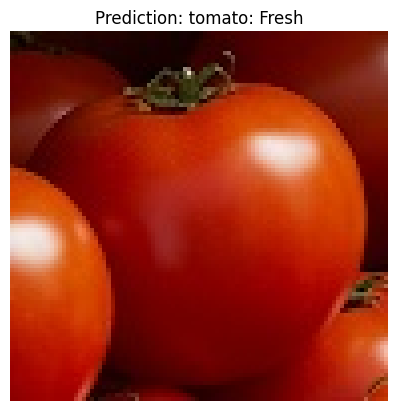

Processing: unnamed (1)_13.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


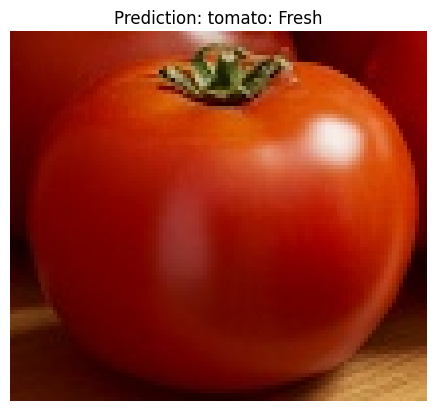

Processing: unnamed (2)_10.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/step


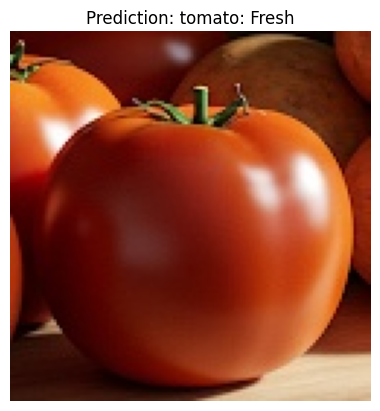

Processing: unnamed (2)_6.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


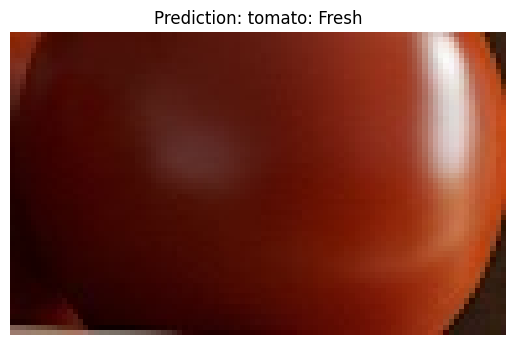

Processing: unnamed (1)_12.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


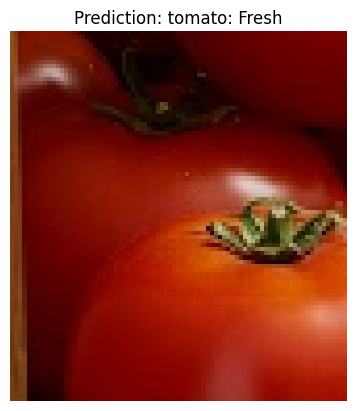

Processing: unnamed_7.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


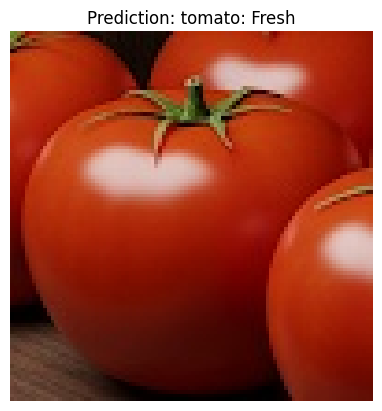

Processing: unnamed_9.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/step


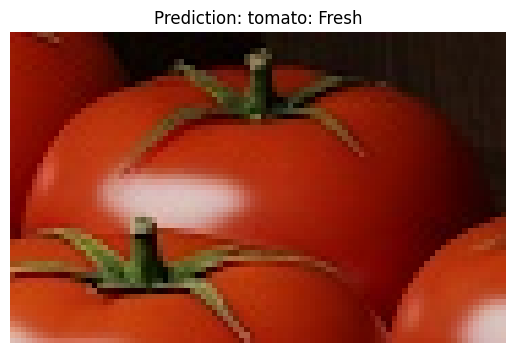

Processing: unnamed (1)_10.jpg in tomato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


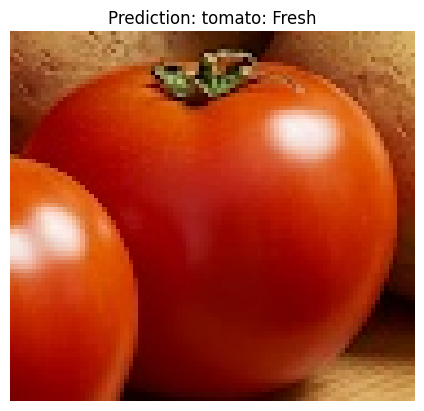

Processing: unnamed (2)_3.jpg in potato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


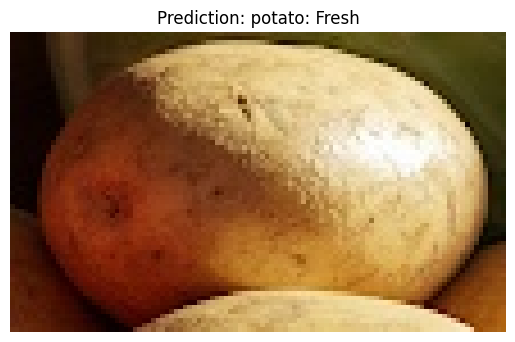

Processing: unnamed (1)_1.jpg in potato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


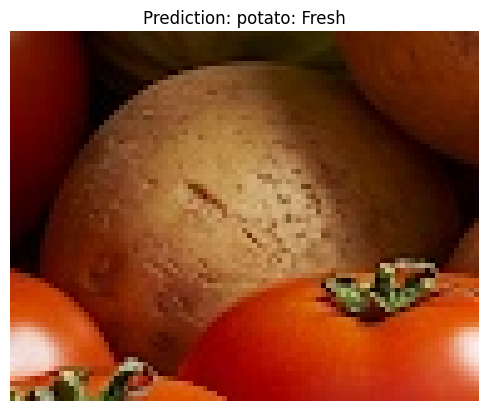

Processing: unnamed (2)_11.jpg in potato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step


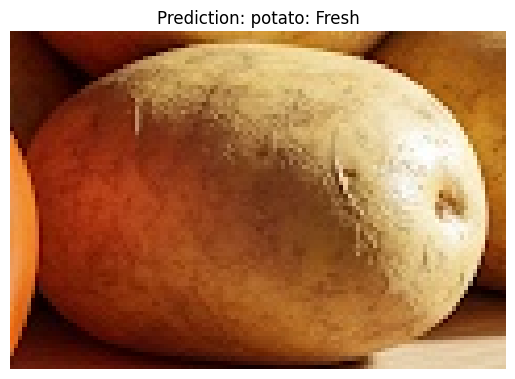

Processing: unnamed (1)_18.jpg in potato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


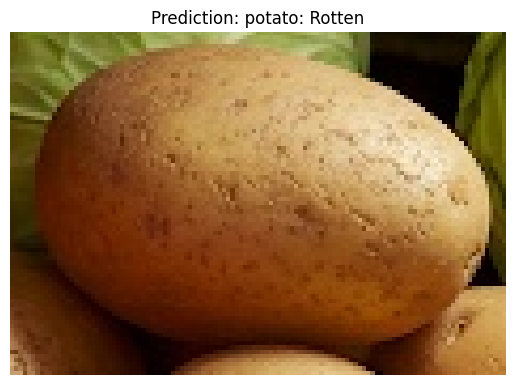

Processing: unnamed (2)_13.jpg in potato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step


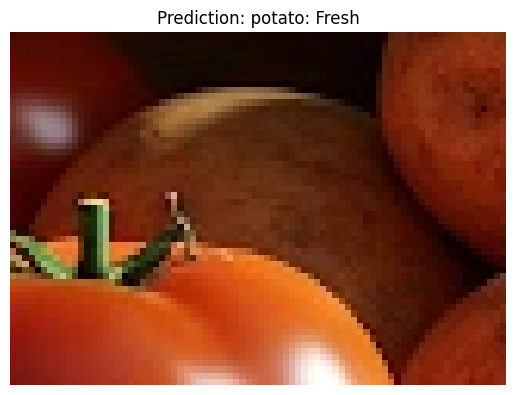

Processing: unnamed_12.jpg in potato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step


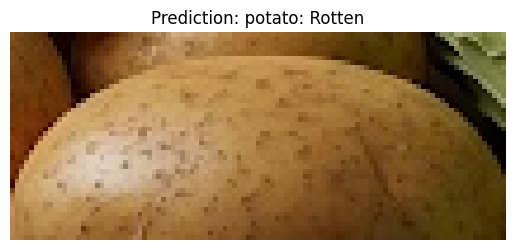

Processing: unnamed_11.jpg in potato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step


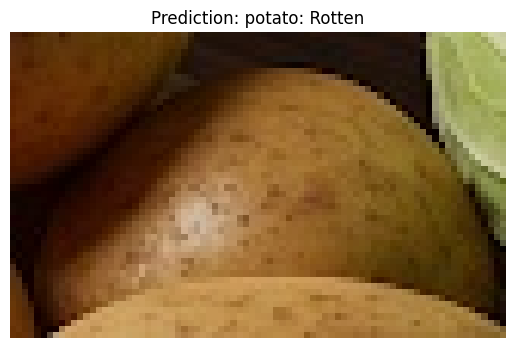

Processing: unnamed_1.jpg in potato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step


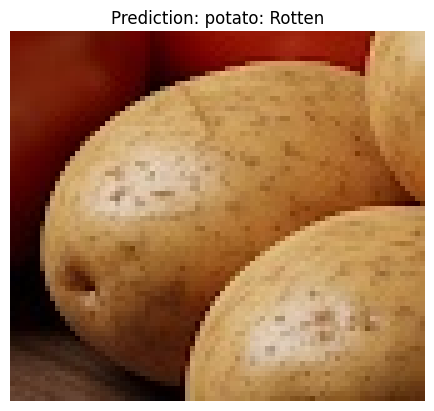

Processing: unnamed (1)_14.jpg in potato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 16ms/step


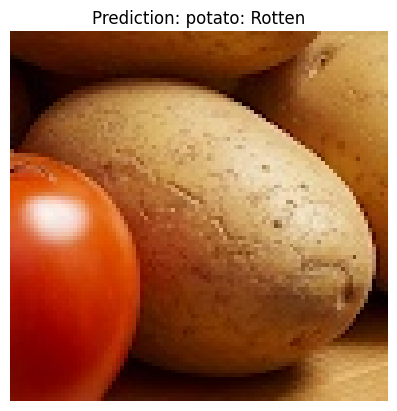

Processing: unnamed_0.jpg in potato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step


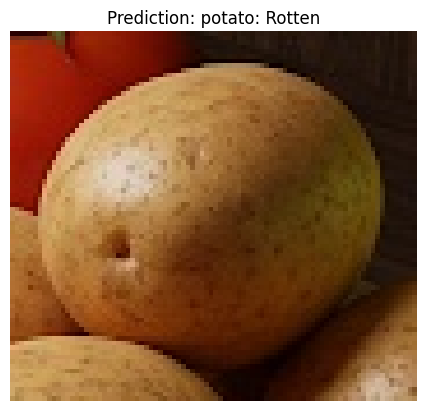

Processing: unnamed (2)_0.jpg in potato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step


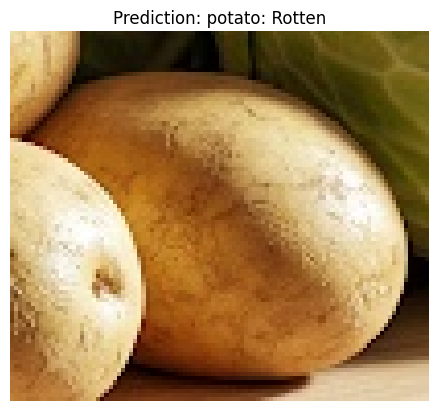

Processing: unnamed_3.jpg in potato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


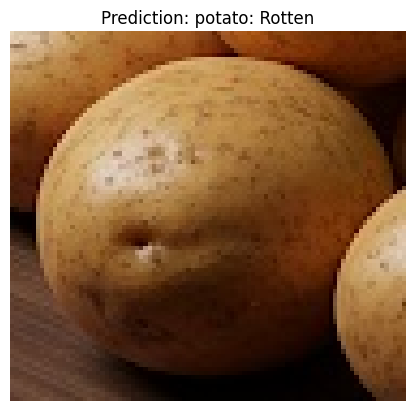

Processing: unnamed (1)_15.jpg in potato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18ms/step


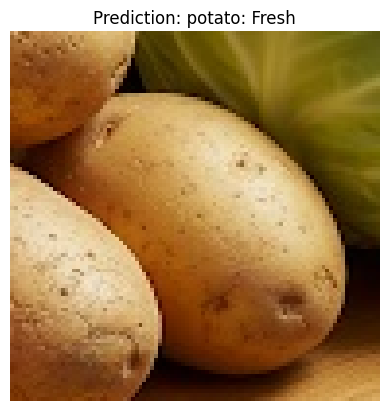

Processing: unnamed_5.jpg in potato
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 21ms/step


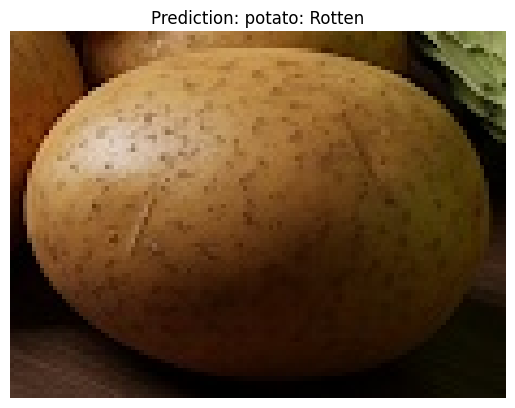

In [6]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("/kaggle/input/model_main/tensorflow2/default/1/fresh_rotten_model.h5")
print("Model loaded successfully.")

# Function to classify a single image and include the folder name in the label
def classify_image(img_path, folder_name):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))  # Resize to match training dimensions
    img = img.astype('float32') / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)[0][0]  # Get prediction
    label = "Fresh" if prediction < 0.5 else "Rotten"
    final_label = f"{folder_name}: {label}"  # Include folder name in the label

    # Display Image with Prediction
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Prediction: {final_label}")
    plt.show()

# Function to classify all images in subfolders of the cropped_images folder
def classify_images_in_folder(root_folder):
    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):  # Ensure it's a folder
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                if img_name.lower().endswith(('png', 'jpg', 'jpeg')):  # Ensure only image files
                    print(f"Processing: {img_name} in {folder_name}")
                    classify_image(img_path, folder_name)

# Example Usage
test_folder_path = "/kaggle/working/cropped_images"  # Root folder containing subfolders
classify_images_in_folder(test_folder_path)
